In [1]:
import pandas as pd

data = pd.read_csv('/kaggle/input/sound-environment/trained_environmental_sound_classification_50.csv')

In [2]:
data.head()

,filename,prediction,confidence
0,5-257349-A-15.wav,Silence,0.225412
1,5-195557-A-19.wav,Thunderstorm,0.843202
2,2-122820-B-36.wav,Vehicle,0.787134
3,1-115920-A-22.wav,Explosion,0.508720
4,1-172649-C-40.wav,Animal,0.531032


In [3]:
# Define a threshold for confidence to classify sounds as real or fake
threshold = 0.5

def classify_sound(confidence):
    return 'Real' if confidence >= threshold else 'Fake'

# Apply the classification to the dataframe
data['sound_type'] = data['confidence'].apply(classify_sound)
data

,filename,prediction,confidence,sound_type
0,5-257349-A-15.wav,Silence,0.225412,Fake
1,5-195557-A-19.wav,Thunderstorm,0.843202,Real
2,2-122820-B-36.wav,Vehicle,0.787134,Real
3,1-115920-A-22.wav,Explosion,0.508720,Real
4,1-172649-C-40.wav,Animal,0.531032,Real
...,...,...,...,...
1958,1-115546-A-48.wav,Silence,0.491329,Fake
1959,3-128512-B-47.wav,Vehicle,0.452849,Fake
1960,3-164594-A-15.wav,Silence,0.865369,Real
1961,2-72547-D-14.wav,Animal,0.120179,Fake


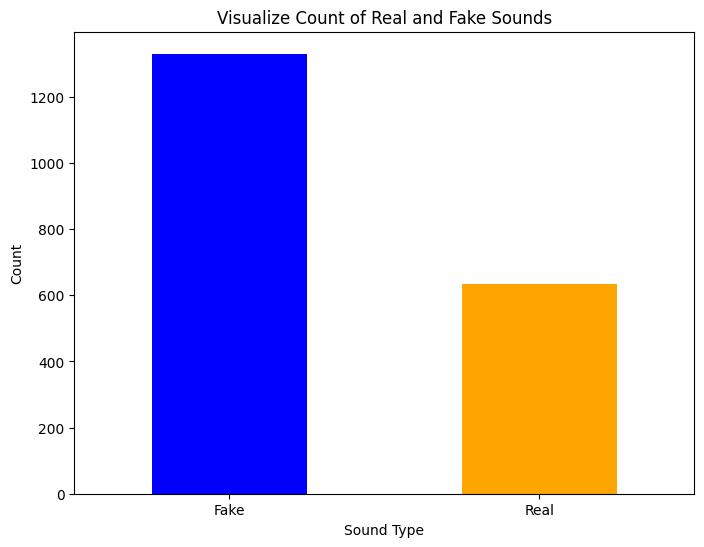

In [4]:
import matplotlib.pyplot as plt

# Count the occurrences of each sound type
sound_type_counts = data['sound_type'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
sound_type_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Visualize Count of Real and Fake Sounds')
plt.xlabel('Sound Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Apply label encoding to 'prediction' and 'sound_type' columns
data['prediction_encoded'] = label_encoder.fit_transform(data['prediction'])
data['sound_type_encoded'] = label_encoder.fit_transform(data['sound_type'])

In [6]:
# Setup X and y 
X = data['prediction_encoded']
y = data['sound_type_encoded']

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.utils import to_categorical

# Convert y to categorical for multi-class classification
y_categorical = to_categorical(y)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays to store all predictions and true labels
all_predictions = []
all_true_labels = []

# Perform K-Fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values.reshape(-1, 1))
    X_test_scaled = scaler.transform(X_test.values.reshape(-1, 1))

    # Define the neural network model architecture
    def build_model(input_dim, num_classes):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    # Build and train the model
    model = build_model(input_dim=X_train_scaled.shape[1], num_classes=y_train.shape[1])

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    # Train the model
    model.fit(
        X_train_scaled, y_train,
        epochs=5, batch_size=32,
        validation_data=(X_test_scaled, y_test),
        callbacks=[early_stop], verbose=1
    )

    # Predict probabilities on the test set
    y_pred_proba = model.predict(X_test_scaled)

    # Store the predictions and true labels
    all_predictions.append(y_pred_proba)
    all_true_labels.append(y_test)

# Combine all predictions and true labels
y_pred_proba_all = np.vstack(all_predictions)
y_true_all = np.vstack(all_true_labels)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_true_all, y_pred_proba_all, multi_class='ovr')

roc_auc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6294 - val_loss: 0.5783
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5797 - val_loss: 0.5762
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6113 - val_loss: 0.5710
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5935 - val_loss: 0.5733
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6539 - val_loss: 0.6153
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5947 - val_loss: 0.6077
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5968 - val_loss: 0.6049
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6005 - val_loss: 0.6024
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5811 - val_loss: 0.5997
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6209 - val_loss: 0.6169
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5910 - val_loss: 0.6131
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5813 - val_loss: 0.6124
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5847 - val_loss: 0.6128
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6340 - val_loss: 0.5976
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6014 - val_loss: 0.5950
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6019 - val_loss: 0.5930
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6152 - val_loss: 0.5917
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5940 - val_loss: 0.5898
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6707 - val_loss: 0.5956
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6029 - val_loss: 0.5906
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6145 - val_loss: 0.5887
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6031 - val_loss: 0.5859
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5945 - val_loss: 0.5851
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


0.6749346708002233

In [11]:
import pickle

# Save the trained model to a pickle file
with open('trained_environment_model.pkl', 'wb') as file:
    pickle.dump(model, file)

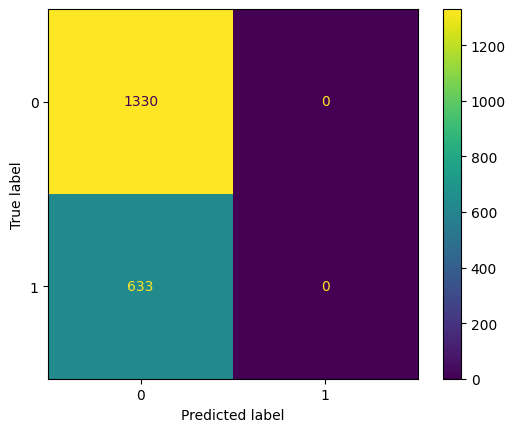

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
y_pred_classes = y_pred_proba_all.argmax(axis=1)
y_true_classes = y_true_all.argmax(axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix without grid
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.grid(False)
plt.show()

- Based on the results from the confusion matrix, the model correctly identified all instances of fake sounds and no real sounds.